# Libraries

In [1]:
# !pip install --upgrade torchvision

!pip install imblearn
import os
import pandas as pd
import numpy as np
import cv2
import torch
from torchvision import models, transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import shutil
import zipfile
import glob
import imagehash
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import random
import torch.nn as nn

# Build Inception model
from collections import namedtuple
import warnings
import torch.nn.functional as F
from torch.jit.annotations import Optional
from torch import Tensor
from sklearn.metrics import precision_score, recall_score, f1_score
import requests

# Device 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load preprocessd data

In [3]:
train_df = pd.read_csv('all_data/train/images_metadata.csv')
valid_df = pd.read_csv('all_data/val/images_metadata.csv')
test_df = pd.read_csv('all_data/test/images_metadata.csv')

# unique class names and sort them
all_classes = sorted(os.listdir('all_data/train/classes'))
unique_class_names = all_classes
class_to_idx = {class_name: idx for idx, class_name in enumerate(all_classes)}
print("Class Dictionary:", class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}

Class Dictionary: {'beaver': 0, 'butterfly': 1, 'cougar': 2, 'crab': 3, 'crayfish': 4, 'crocodile': 5, 'dolphin': 6, 'dragonfly': 7, 'elephant': 8, 'flamingo': 9, 'kangaroo': 10, 'leopard': 11, 'llama': 12, 'lobster': 13, 'octopus': 14, 'pigeon': 15, 'rhino': 16, 'scorpion': 17}


In [4]:
print(valid_df.shape)

(6438, 2)


In [5]:
# idx_to_class_all = idx_to_class.copy()
# class_to_idx_all = class_to_idx.copy()

# train_df['Class'] = train_df['Class'].astype(str)
# train_df.iloc[:, 1] = train_df.iloc[:, 1].astype(int).map(idx_to_class)
# valid_df['Class'] = valid_df['Class'].astype(str)
# valid_df.iloc[:, 1] = valid_df.iloc[:, 1].astype(int).map(idx_to_class)
# test_df['Class'] = test_df['Class'].astype(str)
# test_df.iloc[:, 1] = test_df.iloc[:, 1].astype(int).map(idx_to_class)

# # List of desired classes
# unique_class_names = sorted(['crab','crayfish','lobster','scorpion'])

# train_df = train_df[train_df['Class'].isin(unique_class_names)]
# valid_df = valid_df[valid_df['Class'].isin(unique_class_names)]
# test_df = test_df[test_df['Class'].isin(unique_class_names)]

# class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_class_names)}
# idx_to_class = {v: k for k, v in class_to_idx.items()}

# train_df.iloc[:, 1] = train_df.iloc[:, 1].map(class_to_idx).astype(int)
# valid_df.iloc[:, 1] = valid_df.iloc[:, 1].map(class_to_idx).astype(int)
# test_df.iloc[:, 1] = test_df.iloc[:, 1].map(class_to_idx).astype(int)

In [6]:
print("Train Shape:",train_df.shape)
print("Val Shape:",valid_df.shape)
print("Test Shape:",test_df.shape)

Train Shape: (21563, 2)
Val Shape: (6438, 2)
Test Shape: (2760, 2)


# Parameters

In [7]:
BATCH_SIZE = 128
SIZE= 300
SHAPE = (SIZE,SIZE)

# Custom Transforms

In [8]:
class RandomSharpness:

    def __init__(self, probability=0.5, sharpness_factor_range=(0.5, 5.0)):
        self.probability = probability
        self.sharpness_factor_range = sharpness_factor_range

    def __call__(self, img):
        if random.random() < self.probability:
            sharpness_factor = random.uniform(*self.sharpness_factor_range)
            enhancer = ImageEnhance.Sharpness(img)
            return enhancer.enhance(sharpness_factor)
        return img

class RandomAffineDynamic:
    def __init__(self, max_translate=0.1, max_shear=15, scale_range=(0.7, 1.3)):
        self.max_translate = max_translate
        self.max_shear = max_shear
        self.scale_range = scale_range

    def __call__(self, img):
        translate = (random.uniform(-self.max_translate, self.max_translate),
                     random.uniform(-self.max_translate, self.max_translate))
        shear = random.uniform(-self.max_shear, self.max_shear)
        scale = (random.uniform(*self.scale_range), random.uniform(*self.scale_range))
        return TF.affine(img, angle=0, translate=translate, scale=scale[0], shear=shear)


class RandomGaussianBlur:
    def __init__(self, probability=0.5, kernel_range=(1, 4)):
        self.probability = probability
        self.kernel_range = kernel_range


    def __call__(self, img):
        if random.random() < self.probability:
            kernel_size = random.randint(self.kernel_range[0], self.kernel_range[1]) * 2 + 1
            return TF.gaussian_blur(img, kernel_size)
        return img



class RandomColorJitterDynamic:
    def __init__(self, probability=0.5, brightness_range=(0.5, 1.5), contrast_range=(0.1, 0.5), saturation_range=(0.1, 0.5)):
        self.probability = probability
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.saturation_range = saturation_range

    def __call__(self, img):
        if random.random() < self.probability:
            brightness = random.uniform(*self.brightness_range)
            contrast = random.uniform(*self.contrast_range)
            saturation = random.uniform(*self.saturation_range)
            jitter = T.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation)
            return jitter(img)
        return img

# Transforms

In [9]:
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    # T.RandomResizedCrop(SHAPE, scale=(0.8, 1.0)),
    RandomColorJitterDynamic(probability=0.5),
    # RandomGaussianBlur(probability=0.3),
    RandomAffineDynamic(max_translate=0.05, max_shear=10, scale_range=(0.9, 1.1)),  # Slight scaling and translation
    RandomSharpness(probability=0.5),
    T.Resize(SHAPE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Added for occlusion
])

Basic_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(SHAPE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Visualize Transform

In [10]:
# # Create a 3x3 subplot
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# # Iterate over each subplot and display an image
# for i, ax in enumerate(axes.flat):
#     image_path = train_df['imgpath'][1]
#     # Check the file exists
#     if not os.path.exists(image_path):
#         print(f"Error: Image file not found at {image_path}")
#         break

#     image = cv2.imread(image_path)
#     if image is None:
#         print(f"Error: Failed to load image at {image_path}")
#         break

#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Apply transformation (if any)
#     transformed_image = train_transform(image)
#     # Convert tensor to NumPy array
#     image_np = transformed_image.numpy()
#     image_np = image_np.transpose(1, 2, 0)  # Transpose dimensions for display
#     # Scale the image back to 0-255 range
#     image_np = image_np * 255
#     # Display the image in the subplot
#     ax.imshow(image_np.astype('uint8'))
#     ax.axis('off')

# # Adjust spacing and show the grid of images
# plt.tight_layout()
# plt.show()


# Solve unbalance

In [11]:
# Compute class weights
class_labels = train_df['Class'].values.astype(int)  # Ensure labels are integers
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(train_df['Class'].unique()),
    y=class_labels
)

# Convert to PyTorch tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Map class labels to their corresponding weights
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create sample weights for WeightedRandomSampler
class_labels_tensor = torch.tensor(class_labels, dtype=torch.long).to(device)  # Ensure on same device
sample_weights = class_weights[class_labels_tensor]

# Define WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights.cpu(),  # `WeightedRandomSampler` requires CPU tensor
    num_samples=len(sample_weights),
    replacement=True
)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()))).to(device)

# Build Data Loader 

In [26]:
class AnimalDataset(Dataset):

    def __init__(self, df, transform=None):
        self.transform = transform
        self.img_paths = df['imgpath'].tolist()
        self.classes = df['Class'].tolist()
        # self.images = []
        # for img_name in self.img_paths:
        #   image = cv2.imread(img_name)
        #   image= Basic_transform(image)
        #   self.images.append(image)

    def __len__(self):
        return len(self.img_paths)


    def __getitem__(self, idx):
        # print(f"idx:{idx}, len:{len(self.img_paths)}")
        img_name = self.img_paths[idx]
        label = self.classes[idx]
        image = cv2.imread(img_name)
        # image = self.images[idx]
        image = self.transform(image)
        return image, label, img_name


def prepare_dataloaders(df, BT, transform=None, Balance=False, Shuffle=False):
    # Create dataset
    dataset = AnimalDataset(df, transform=transform)
    # If balance is True, apply class weighting
    if Balance:
        dataloader = DataLoader(dataset, batch_size=BT, sampler=sampler)
    else:
        dataloader = DataLoader(dataset, batch_size=BT, shuffle=Shuffle)
    return dataloader

train_dataloader = prepare_dataloaders(train_df, BATCH_SIZE, transform=train_transform, Balance=True, Shuffle=True)
val_dataloader = prepare_dataloaders(valid_df, 1, transform=Basic_transform)
test_dataloader = prepare_dataloaders(test_df, 1, transform=Basic_transform)

# Predict sample

In [13]:
def predictOne(model, image):
    model.to(device)
    model.eval()
    image = image.to(device)
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    outputs = model(image)

    # Handle Inception-specific output
    if isinstance(outputs, tuple) or hasattr(outputs, '_fields'):
        outputs = outputs[0]  # Use the main logits for loss calculation

    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
    max_prob, predicted = torch.max(probabilities, 1)

    return predicted.item(), max_prob.item()


# Predict With Yolo

In [14]:
def Predict_With_Yolo(model, img, threshold=0.7, threshold2=0.7):
    detection_results = yolo_model(img, verbose=False)
    highest_class, highest_prob = predictOne(model, img)

    if highest_prob < threshold:
        for result in detection_results:
            boxes = result.boxes.xyxy  # Bounding box coordinates
            scores = result.boxes.conf  # Detection confidence scores
            classes = result.boxes.cls  # Class indices

            for i, box in enumerate(boxes):
                if scores[i] < threshold2:
                    continue

                x1, y1, x2, y2 = map(int, box)  # Convert bounding box coordinates to integers
                detected_object = img[y1:y2, x1:x2]

                if detected_object.size == 0:  # Skip invalid boxes
                    continue

                # Classify the detected object
                label, prob = predictOne(model, detected_object)
                prob *= scores

                # Update the highest probability and corresponding class
                if prob > highest_prob:
                    highest_class = label
                    highest_prob = prob

    return highest_class, highest_prob

# Plot metrics

In [15]:
def plot_metrics(train_precisions, train_recalls, train_f1s, val_precisions, val_recalls, val_f1s):
    epochs = range(1, len(train_precisions) + 1)

    plt.figure(figsize=(15, 5))

    # Precision
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_precisions, label='Train Precision', color='blue')
    plt.plot(epochs, val_precisions, label='Val Precision', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision over Epochs')
    plt.legend()
    plt.grid(True)

    # Recall
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_recalls, label='Train Recall', color='blue')
    plt.plot(epochs, val_recalls, label='Val Recall', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall over Epochs')
    plt.legend()
    plt.grid(True)

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1s, label='Train F1 Score', color='blue')
    plt.plot(epochs, val_f1s, label='Val F1 Score', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_training_results(train_accuracies, train_losses, val_accuracies, val_losses):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Train function

In [35]:
def train_model(model, model_name, learn=0.001, num_epochs=10, early_stopping_patience=3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learn, weight_decay=1e-3)
    model.train()
    train_accuracies = []
    train_losses = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []
    val_accuracies = []
    val_losses = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []
    correct_predictions = 0
    total_predictions = 0
    last_f1 = 0
    cnt = 0
    final_weights = None
    mx_acc_val = 0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        all_labels = []
        all_predictions = []
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for images, labels, _ in train_dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                # Handle models with auxiliary outputs
                if isinstance(outputs, tuple) or hasattr(outputs, '_fields'):
                    main_output, *aux_outputs = outputs
                    loss = criterion(main_output, labels)
                    # this for fine-tuning (Auxiliary loss weight)
                    for aux_output in aux_outputs:
                        loss += 0.2 * criterion(aux_output, labels) 
                else:
                    loss = criterion(outputs, labels)
                    main_output = outputs
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                _, predicted = torch.max(main_output, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                epoch_correct += (predicted == labels).sum().item()
                epoch_total += labels.size(0)
                pbar.update(1)
        epoch_accuracy = (epoch_correct / epoch_total) * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        train_recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        train_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1_scores.append(train_f1)
        val_accuracy, val_loss, val_precision, val_recall, val_f1 = calculate_validation_metrics(model, val_dataloader, criterion)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}, Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Precision: {val_precision:.2f}, Validation Recall: {val_recall:.2f}, Validation F1: {val_f1:.2f}")
        if val_f1 < last_f1:
            cnt += 1
        else:
            cnt = 0
        last_f1 = val_f1
        if cnt == early_stopping_patience:
            print("Early stopping triggered due to increasing loss in last 3 epochs.")
            break
        if val_f1 > mx_acc_val:
            final_weights = model.state_dict().copy()
            print(f'New Max Accuracy: {val_f1}')
            file_path = f"{model_name}_f1_{mx_acc_val:.4f}_final_weights.pth"
            if os.path.exists(file_path):
                os.remove(file_path)
            torch.save(final_weights, f"{model_name}_f1_{val_f1:.4f}_final_weights.pth")
            print(f"Model {model_name} weights saved.")
            mx_acc_val = val_f1
    plot_training_results(train_accuracies, train_losses, val_accuracies, val_losses)
    plot_metrics(train_precisions, train_recalls, train_f1_scores, val_precisions, val_recalls, val_f1_scores)

# calculate validation metrics

In [17]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

def calculate_validation_metrics(model, val_dataloader, display_confusion_matrix=False):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_predictions = 0
    val_loss = 0.0

    all_labels = []
    all_predictions = []

    with tqdm(total=len(val_dataloader), desc="Validating") as pbar:
        for images, labels, imgpaths in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle Inception-specific output
            if isinstance(outputs, tuple) or hasattr(outputs, '_fields'):
                outputs = outputs[0]  # Use the main logits for loss calculation

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)

            # Convert indices to class names and extend the lists
            all_labels.extend([idx_to_class[label] for label in labels.cpu().numpy()])
            all_predictions.extend([idx_to_class[pred] for pred in predicted.cpu().numpy()])

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += len(labels)
            pbar.update(1)
    # Calculate validation accuracy and loss
    accuracy = (correct_predictions / total_predictions) * 100
    avg_val_loss = val_loss / len(val_dataloader)

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    if display_confusion_matrix:
        # Generate Confusion Matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions,labels=unique_class_names)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_class_names)
        disp.plot(cmap='viridis', values_format='d',xticks_rotation=90)  # Display the matrix
        # print("Confusion Matrix:")
        # print(conf_matrix)

    model.train()  # Set the model back to training mode

    return accuracy, avg_val_loss, precision, recall, f1

def calculate_validation_accuracy_loss(model, val_dataloader, criterion=torch.nn.CrossEntropyLoss()):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    val_loss = 0.0

    with tqdm(total=len(val_dataloader), desc="Validating") as pbar:
        for images, labels, imgpaths in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple) or hasattr(outputs, '_fields'):
                outputs = outputs[0]  # Use the main logits for loss calculation
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += len(labels)
            pbar.update(1)

    accuracy = (correct_predictions / total_predictions) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    model.train()  # Set the model back to training mode
    return accuracy, avg_val_loss


# Get test Accuracy

In [18]:
def calculate_labeled_test_accuracy(model, tes_dataloader, Yolo):
    model = model.to(device)
    model.eval()
    Predict_fun = predictOne

    if Yolo:
        yolo_model.to(device)
        yolo_model.eval()
        Predict_fun = Predict_With_Yolo

    correct_predictions = 0
    total_predictions = 0

    with tqdm(total=len(tes_dataloader), desc="Testing") as pbar:
        for images, labels, imgpaths in tes_dataloader:
            batch_correct = 0
            for img, label in zip(images, labels):
                highest_class, highest_prob = Predict_fun(model, img)
                if highest_class == label:
                    batch_correct += 1
            correct_predictions += batch_correct
            total_predictions += len(labels)
            pbar.update(1)

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


# Generate predictions csv for unseen test

In [19]:
def gen_predictions_unlabeled_test(model, model_name,Yolo,threshold=0.7):
    print(f"Testing {model_name}...")
    model = model.to(device)
    model.eval()
    if Yolo:
        yolo_model.to(device)
        yolo_model.eval()
    predictions = []
    test_data = pd.DataFrame({"ImageID": os.listdir(test_images_folder)})
    with torch.no_grad():
        for image_id in tqdm(test_data["ImageID"], desc="Testing"):
            image_path = os.path.join(test_images_folder, image_id)
            if Yolo:
                highest_class,highest_prob = Predict_With_Yolo(model,image_path)
            else:
                img = cv2.imread(image_path)
                if img is None:
                    highest_class = None
                else:
                    img = Basic_transform(img)
                    highest_class,highest_prob = predictOne(model,img)
            if highest_class is None:
                predictions.append({"ImageID": image_id, "Class":0, "Probability": -1})
                continue
            predictions.append({"ImageID": image_id, "Class":highest_class , "Probability": highest_prob})
    # Sort the predictions list by 'Probability' in ascending order
    predictions = sorted(predictions, key=lambda x: x['Probability'])
    accuracy= calculate_accuracy_with_threshold(predictions,threshold)
    for prediction in predictions:
        prediction.popitem()  # Removes the last key-value pair
    # Save predictions to CSV, sorted by Probability in ascending order
    output_df = pd.DataFrame(predictions)
    output_path = f"{model_name}_{threshold}_{accuracy * 100:.2f}%_predictions.csv"
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}.")
def calculate_accuracy_with_threshold(predictions, threshold=0.5):
    neglected = 0
    misclassification=0
    for pred in predictions:
        if pred['Probability']==-1:
            neglected+=1
        elif pred['Probability']<threshold:
            misclassification+=1
        else:
            break;
    total = len(predictions) - neglected
    accuracy = (total-misclassification)/total
    print(f"Accuracy of test with threshold {threshold}: {accuracy * 100:.2f}%")
    return accuracy

# Load Wieghts

In [20]:
def load_weights(model,weights_path):
    # Load the state dictionary from the .pth file
    state_dict = torch.load(weights_path)
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)

# Resnet Implementation

In [21]:
# Build Resnet models
model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, s3
    tride=stride, bias=False, padding=1)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Block(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(Block, self).__init__()
        
        width = planes
        
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * 4)
        self.bn3 = norm_layer(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, layers):
        super(ResNet, self).__init__()
        num_classes = 1000
        
        self.norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = self.norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, layers[0], stride=1)
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = nn.Sequential(
            conv1x1(self.inplanes, planes * 4, stride),
            self.norm_layer(planes * 4)
        )
        layers = [Block(self.inplanes, planes, stride, downsample, self.norm_layer)]
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(Block(self.inplanes, planes, norm_layer=self.norm_layer))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def Resnet50():
    return ResNet([3, 4, 6, 3])

def Resnet101():
    return ResNet([3, 4, 23, 3])

def Resnet152():
    return ResNet([3, 8, 36, 3])

# Inception Implementation

In [30]:
# url    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': torch.Tensor, 'aux_logits': Optional[torch.Tensor]}

# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs

class Inception3(nn.Module):
    def __init__(self, num_classes=1000):
        super(Inception3, self).__init__()
        
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, num_classes)

    def _forward(self, x):
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        aux = self.AuxLogits(x) if self.training else None
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, aux

    @torch.jit.unused
    def eager_outputs(self, x, aux):
        if self.training:
            return InceptionOutputs(x, aux)
        else:
            return x

    def forward(self, x):
        x, aux = self._forward(x)
        if torch.jit.is_scripting():
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)

class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)
        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3(x)
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)
        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        
        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)
        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class InceptionD(nn.Module):
    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)
        
        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class InceptionE(nn.Module):
    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)
        
        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))
        
        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))
        
        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)
        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        x = self.conv0(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


# Transformer Model

In [ ]:
from einops import rearrange
from einops.layers.torch import Reduce

# helpers
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head, dropout),
                FeedForward(dim, mlp_dim, dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup
        assert expansion != 1, 'not handeled expansion = 1'
        self.conv = nn.Sequential(
            nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),

            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()

        self.ph = self.pw = patch_size
        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)
        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)
        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()
        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)        
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)
        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT(nn.Module):
    def __init__(self, image_size=SIZE, dims=None, channels=None, num_classes=18, expansion=4, kernel_size=3, patch_size=8, depths=(2, 4, 3)):
        super().__init__()
        
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'
        assert image_size % patch_size == 0
        
        init_dim, *_, last_dim = channels
        self.conv1 = conv_nxn_bn(3, init_dim, stride=2)
        self.stem = nn.ModuleList([])
        
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.stem.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.stem.append(MV2Block(channels[2], channels[3], 1, expansion))

        self.trunk = nn.ModuleList([])

        self.trunk.append(nn.ModuleList([
            MV2Block(channels[3], channels[4], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[5], kernel_size, patch_size, int(dims[0] * 2))
        ]))

        self.trunk.append(nn.ModuleList([
            MV2Block(channels[5], channels[6], 2, expansion),
            MobileViTBlock(dims[1], depths[1], channels[7], kernel_size, patch_size, int(dims[1] * 4))
        ]))

        self.trunk.append(nn.ModuleList([
            MV2Block(channels[7], channels[8], 2, expansion),
            MobileViTBlock(dims[2], depths[2], channels[9], kernel_size, patch_size, int(dims[2] * 4))
        ]))

        self.to_logits = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
                Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)
        for conv in self.stem:
            x = conv(x)
        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)
        return self.to_logits(x)

mobile_vit = MobileViT(
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
).to(device)


from torchsummary import summary
# summary(mobile_vit, input_size = (3, SIZE, SIZE))

## Inception Training

In [31]:
# Load the Inception v3 model with pretrained weights
inception = Inception3()
inception = inception.to(device)
# download('PreTrained_Inception_weights.pth',"https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth",'')
# load_weights(inception,'PreTrained_Inception_weights.pth')

In [32]:
NumClasses = len(unique_class_names)
print(NumClasses)
inception.AuxLogits.fc = torch.nn.Linear(inception.AuxLogits.fc.in_features,NumClasses)
inception.fc = torch.nn.Linear(inception.fc.in_features, NumClasses)  # For main output
load_weights(inception,'/kaggle/working/Inception_f1_0.9752_final_weights.pth')

18


/tmp/ipykernel_23/2001627106.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Validating: 100%|██████████| 6438/6438 [02:13<00:00, 48.37it/s]


Epoch [1/5], Train Loss: 109.9465, Train Accuracy: 97.76%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.77%, Validation Loss: 0.0494, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9877325137689237
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:11<00:00, 48.93it/s]


Epoch [2/5], Train Loss: 99.1957, Train Accuracy: 97.97%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.79%, Validation Loss: 0.0476, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9878795113820977
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:13<00:00, 48.21it/s]


Epoch [3/5], Train Loss: 90.6478, Train Accuracy: 97.95%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.82%, Validation Loss: 0.0479, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
Early stopping triggered due to increasing loss in last 3 epochs.


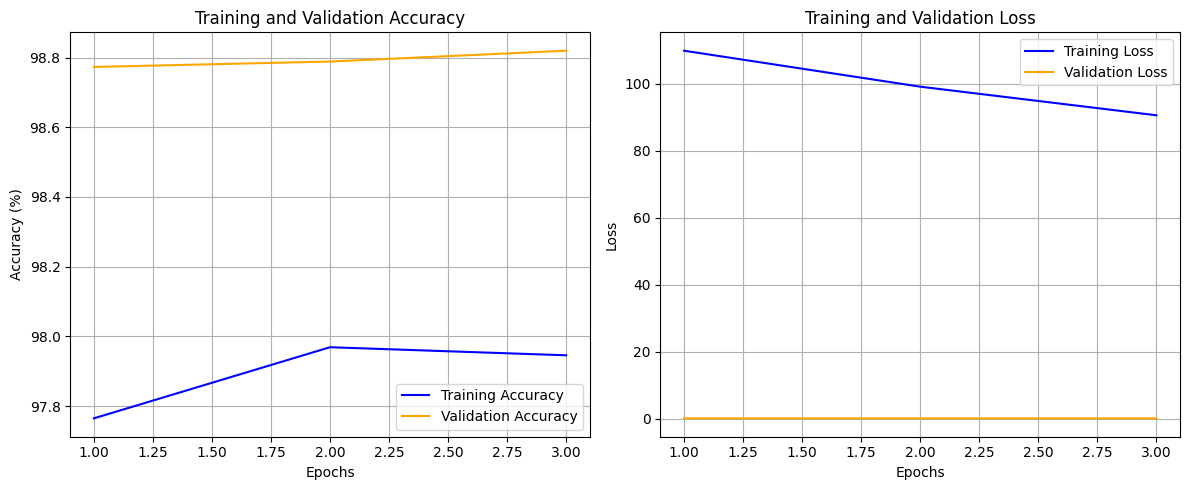

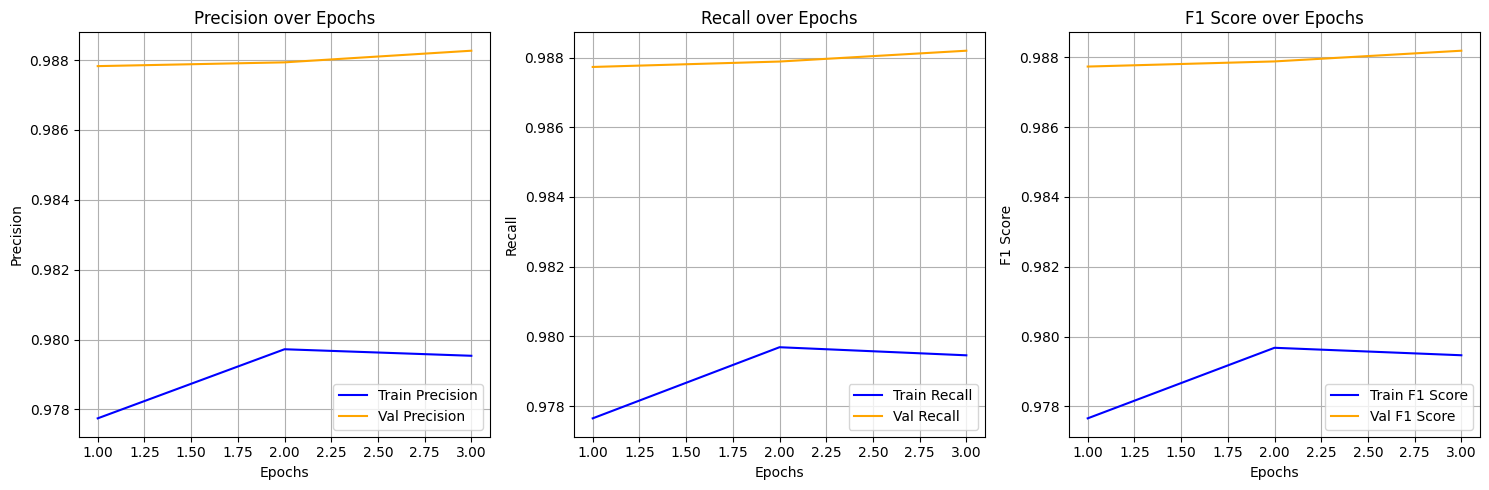

In [33]:
train_model(inception, 'inception', learn=1e-6, num_epochs=5)

Validating: 100%|██████████| 6438/6438 [02:16<00:00, 47.19it/s]


Epoch [1/5], Train Loss: 82.5874, Train Accuracy: 98.04%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.73%, Validation Loss: 0.0498, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9872688144914632
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:20<00:00, 45.75it/s]


Epoch [2/5], Train Loss: 74.3087, Train Accuracy: 98.06%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.80%, Validation Loss: 0.0491, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9880359738723204
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:19<00:00, 46.19it/s]


Epoch [3/5], Train Loss: 67.4067, Train Accuracy: 98.04%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.80%, Validation Loss: 0.0481, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9880431463084806
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:19<00:00, 46.17it/s]


Epoch [4/5], Train Loss: 60.2151, Train Accuracy: 98.18%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.71%, Validation Loss: 0.0497, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99


Validating: 100%|██████████| 6438/6438 [02:20<00:00, 45.67it/s]


Epoch [5/5], Train Loss: 55.1755, Train Accuracy: 98.18%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.76%, Validation Loss: 0.0480, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99


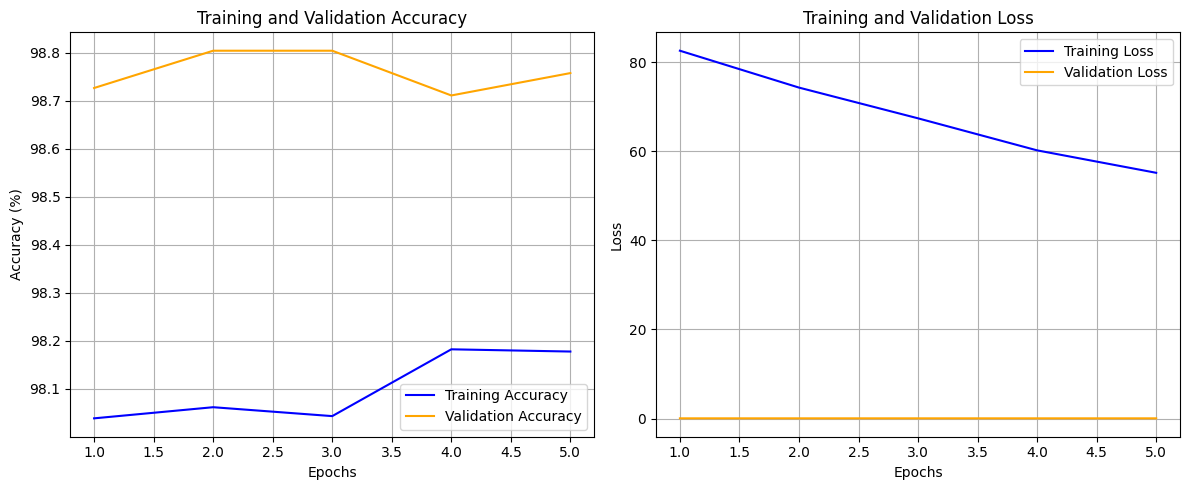

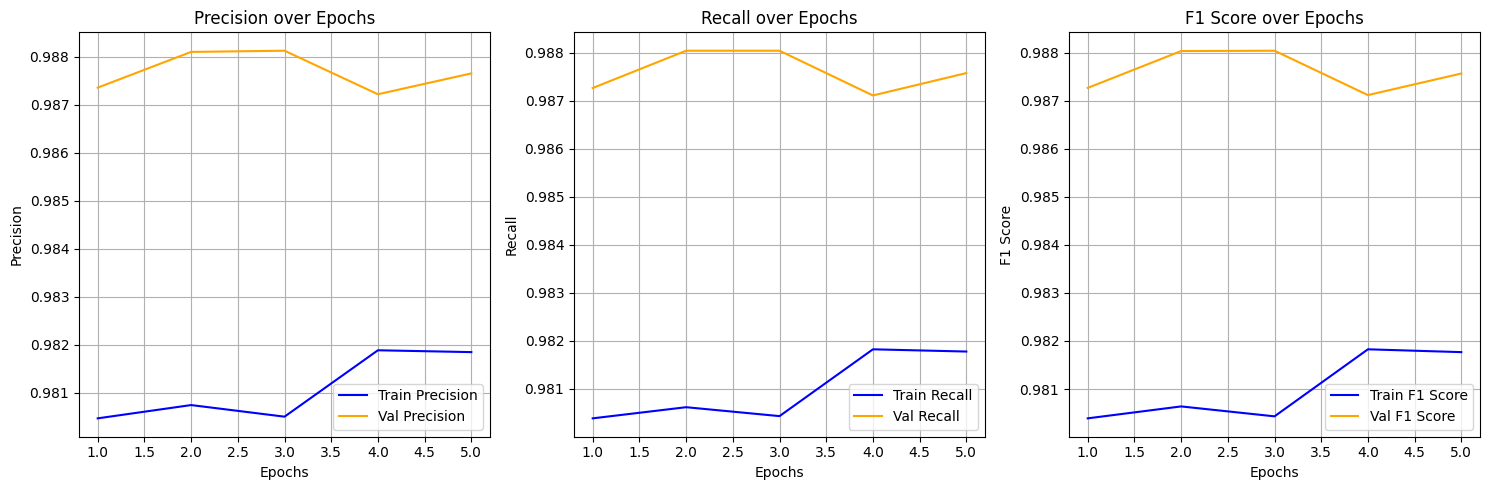

In [37]:
train_model(inception, 'inception', learn=1e-6, num_epochs=5)

In [ ]:
train_model(inception, 'inception', learn=1e-6, num_epochs=5)

Validating: 100%|██████████| 6438/6438 [02:17<00:00, 46.73it/s]


Epoch [1/5], Train Loss: 82.3998, Train Accuracy: 97.99%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.74%, Validation Loss: 0.0483, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9874047192210633
Model inception weights saved.


Validating: 100%|██████████| 6438/6438 [02:17<00:00, 46.81it/s]


Epoch [2/5], Train Loss: 73.9813, Train Accuracy: 98.02%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98, Validation Accuracy: 98.79%, Validation Loss: 0.0481, Validation Precision: 0.99, Validation Recall: 0.99, Validation F1: 0.99
New Max Accuracy: 0.9878964028151824
Model inception weights saved.


Epoch 3/5:  11%|█         | 19/169 [00:58<07:55,  3.17s/it]

## Inception Evaluation

Validating: 100%|██████████| 6438/6438 [02:22<00:00, 45.19it/s]


Val: avg_loss: 0.04795161652145927 
 Accuracy:98.7573780677229
 precision: 0.9876542472695244 
 recall=0.987573780677229 
 f1= 0.9875688485189377 


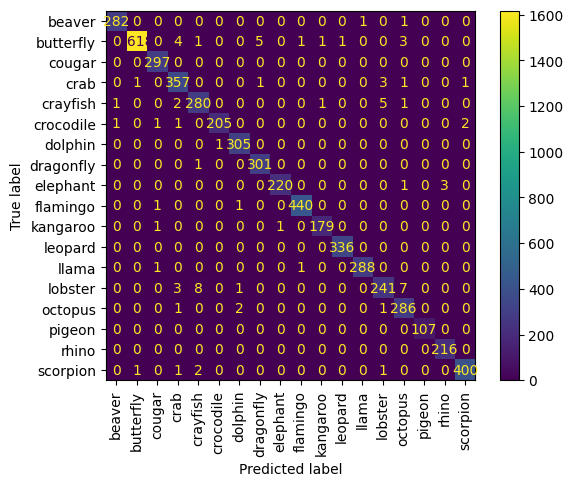

In [38]:
accuracy, avg_val_loss, precision, recall, f1=calculate_validation_metrics(inception,val_dataloader,display_confusion_matrix=True)
print(f"Val: avg_loss: {avg_val_loss} \n Accuracy:{accuracy}\n precision: {precision} \n recall={recall} \n f1= {f1} ")

Validating: 100%|██████████| 2760/2760 [00:59<00:00, 46.46it/s]


Test: avg_loss: 0.04639710816717277 
 Accuracy:98.65942028985508
 precision: 0.9870181085258756 
 recall=0.9865942028985507 
 f1= 0.9866740156842073 


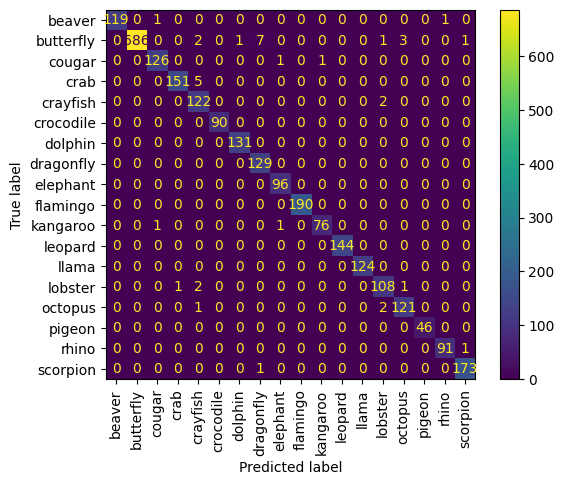

In [39]:
accuracy, avg_val_loss, precision, recall, f1=calculate_validation_metrics(inception,test_dataloader,display_confusion_matrix=True)
print(f"Test: avg_loss: {avg_val_loss} \n Accuracy:{accuracy}\n precision: {precision} \n recall={recall} \n f1= {f1} ")

# Test unlabeled data

In [43]:
load_weights(inception,'/kaggle/working/inception_Accuracy:98.82%_final_weights.pth')
test_images_folder = '/kaggle/input/animal-kingdom-classification/AnimalTestData/AnimalTestData'
gen_predictions_unlabeled_test(inception,'inception_v3',False)

/tmp/ipykernel_23/2001627106.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Testing inception_v3...


Testing: 100%|██████████| 1982/1982 [02:00<00:00, 16.47it/s]

Accuracy of test with threshold 0.7: 94.78%
Predictions saved to inception_v3_0.7_94.78%_predictions.csv.


# Improve see animals Accuracy

In [ ]:
## Model 2
test_labels_df = pd.read_csv('/kaggle/working/special_animals.csv') 
codes = [class_to_idx_all[x] for x in unique_class_names]
for idx in range(len(test_labels_df)):
    image_id = test_labels_df.iloc[idx,0]
    label = test_labels_df.iloc[idx,1]
    if label in codes:
        img_path = os.path.join('/kaggle/input/animal-kingdom-classification/AnimalTestData/AnimalTestData',image_id)
        image = cv2.imread(img_path)
        image = Basic_transform(image)
        predicted,max_prob = predictOne(inception,image)
        class_name = idx_to_class[predicted]
        class_code = class_to_idx_all[class_name]
        test_labels_df.iloc[idx,1] = class_code
        
test_labels_df.to_csv('/kaggle/working/special_animals.csv', index=False)
print('Finished')